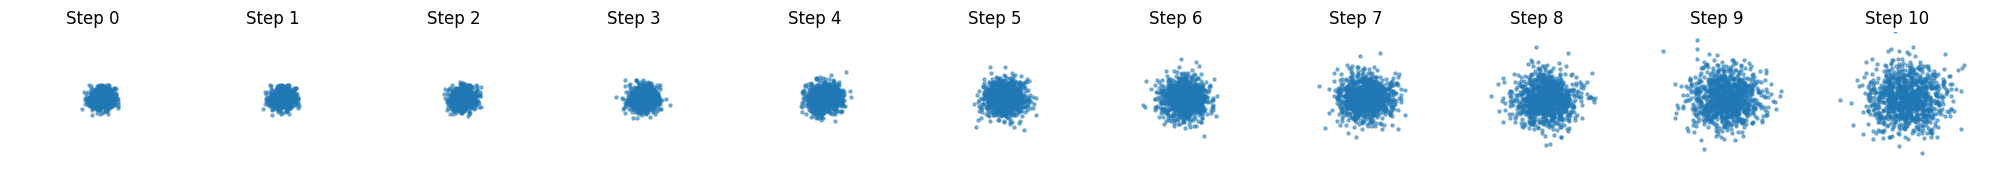

In [1]:
import torch
import matplotlib.pyplot as plt

# Settings
n_samples = 1000
n_steps = 10
noise_levels = torch.linspace(0.01, 1.0, n_steps)

# Step 1: Create simple 2D Gaussian data
mean = torch.tensor([2.0, 2.0])
cov = torch.eye(2) * 0.1
data = torch.distributions.MultivariateNormal(mean, cov).sample((n_samples,))

# Step 2: Forward diffusion — Add progressively more noise
noisy_data = [data]
for sigma in noise_levels:
    noise = torch.randn_like(data) * sigma
    noisy = data + noise
    noisy_data.append(noisy)

# Step 3: Visualize
fig, axes = plt.subplots(1, n_steps + 1, figsize=(20, 2))
for i, d in enumerate(noisy_data):
    ax = axes[i]
    ax.scatter(d[:, 0], d[:, 1], s=5, alpha=0.5)
    ax.set_title(f"Step {i}")
    ax.set_xlim(-3, 6)
    ax.set_ylim(-3, 6)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [22]:
import pandas as pd
pd = pd.read_csv('/home/jamshid/workspace/nima/cdvae/cdvae-main/data/debug_data/val.csv')

In [23]:
pd
pd.head(8).to_csv('/home/jamshid/workspace/nima/cdvae/cdvae-main/data/debug_data/val.csv', index=False)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Generate clean data again
n_samples = 5000
clean_data = torch.distributions.MultivariateNormal(
    torch.tensor([2.0, 2.0]), torch.eye(2) * 0.1
).sample((n_samples,))

# Noise levels
sigmas = torch.tensor([0.01, 0.05, 0.1, 0.2, 0.4, 0.8, 1.0])

# Define dataset for score matching
def make_score_matching_dataset(data, sigmas):
    X, Sigma, Eps = [], [], []
    for sigma in sigmas:
        eps = torch.randn_like(data)
        x_noisy = data + sigma * eps
        X.append(x_noisy)
        Sigma.append(torch.full((len(data), 1), sigma))
        Eps.append(eps)
    return torch.cat(X), torch.cat(Sigma), torch.cat(Eps)

X_noisy, sigma_vals, eps = make_score_matching_dataset(clean_data, sigmas)
dataset = TensorDataset(X_noisy, sigma_vals, eps)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

# Score network: simple MLP
class ScoreNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
        )
        
    def forward(self, x, sigma):
        # Concatenate noise level as input
        x_sigma = torch.cat([x, sigma], dim=1)
        return self.net(x_sigma)

# Initialize model and optimizer
score_model = ScoreNet()
optimizer = optim.Adam(score_model.parameters(), lr=1e-3)

# Training loop
n_epochs = 30
for epoch in range(n_epochs):
    total_loss = 0.0
    for x, sigma, eps in loader:
        score = score_model(x, sigma)
        target = -eps / sigma
        loss = ((score - target) ** 2).sum(dim=1).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}")


Epoch 1: Loss = 818706.4969
Epoch 2: Loss = 817594.1998
Epoch 3: Loss = 816775.3519
Epoch 4: Loss = 816131.7788
Epoch 5: Loss = 815570.4140
Epoch 6: Loss = 815960.0385
Epoch 7: Loss = 815267.2053
Epoch 8: Loss = 816509.1095
Epoch 9: Loss = 816258.0507
Epoch 10: Loss = 815389.5327
Epoch 11: Loss = 815723.4332
Epoch 12: Loss = 817399.3022
Epoch 13: Loss = 814917.4753
Epoch 14: Loss = 815237.1328
Epoch 15: Loss = 817172.1710
Epoch 16: Loss = 815997.4083
Epoch 17: Loss = 816644.0334
Epoch 18: Loss = 816095.9319
Epoch 19: Loss = 814858.3406
Epoch 20: Loss = 815947.0320
Epoch 21: Loss = 815745.0149
Epoch 22: Loss = 814467.0560
Epoch 23: Loss = 815826.8016
Epoch 24: Loss = 814497.7612
Epoch 25: Loss = 815459.3746
Epoch 26: Loss = 815089.8943
Epoch 27: Loss = 815484.9395
Epoch 28: Loss = 815743.8634
Epoch 29: Loss = 816057.9441
Epoch 30: Loss = 814970.3596


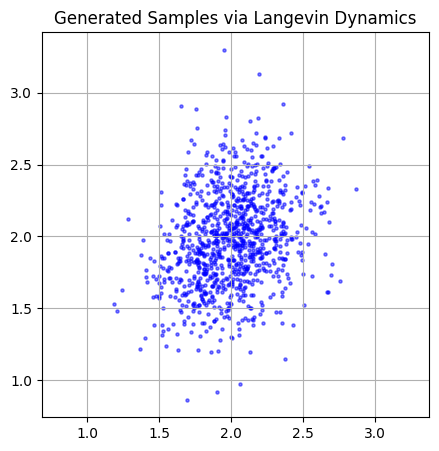

In [10]:
import matplotlib.pyplot as plt

@torch.no_grad()
def langevin_dynamics(score_model, sigmas, n_steps_per_sigma=20, step_size=0.01, n_samples=1000):
    x = torch.randn(n_samples, 2)  # Start from pure noise

    for sigma in reversed(sigmas):
        sigma_tensor = torch.full((n_samples, 1), sigma)
        for _ in range(n_steps_per_sigma):
            noise = torch.randn_like(x)
            grad = score_model(x, sigma_tensor)
            x = x + step_size * grad + torch.sqrt(torch.tensor(2.0 * step_size)) * noise
    return x

# Run sampling
samples = langevin_dynamics(score_model, sigmas)

# Plot
plt.figure(figsize=(5, 5))
plt.scatter(samples[:, 0], samples[:, 1], s=5, alpha=0.5, color='blue')
plt.title("Generated Samples via Langevin Dynamics")
plt.axis("equal")
plt.grid(True)
plt.show()


In [1]:
import datasets
from datasets import load_dataset
# Load a dataset from Hugging Face Hub
data = load_dataset("nimashoghi/mp20")

/home/jamshid/py312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
data['train'].shape[0]+ data['test'].shape[0] + data['val'].shape[0]

45229

In [6]:
data.keys()

dict_keys(['train', 'val', 'test'])

In [4]:
data['train'].data.shape, data['test'].data.shape

((27136, 13), (9046, 13))

In [2]:
from pymatgen.core import Lattice, Structure
from pymatgen.analysis.structure_matcher import StructureMatcher
import nglview as nv
import tempfile
import os

# -------------------------
# 1. Create two structures
# -------------------------

# Define a cubic lattice (5 Å per side)
lattice = Lattice.cubic(5.0)

# Original structure
structure_1 = Structure(
    lattice,
    ["Si", "Si"],
    [[0, 0, 0], [0.25, 0.25, 0.25]]
)

# Perturbed structure (slightly shifted atoms)
structure_2 = Structure(
    lattice,
    ["Si", "Si"],
    [[0.01, -0.01, 0.0], [0.26, 0.24, 0.25]]
)

# -------------------------
# 2. Structure matching
# -------------------------

matcher = StructureMatcher()
are_equal = matcher.fit(structure_1, structure_2)
print("Are the structures equivalent?", are_equal)

# -------------------------
# 3. Visualize using nglview
# -------------------------

# Save temporary CIF files
tmp_dir = tempfile.gettempdir()
file1 = os.path.join(tmp_dir, "structure_1.cif")
file2 = os.path.join(tmp_dir, "structure_2.cif")
structure_1.to(filename=file1)
structure_2.to(filename=file2)

# Load with nglview
view1 = nv.show_file(file1)
view2 = nv.show_file(file2)

# Style & display
view1.clear_representations()
view1.add_ball_and_stick()
view2.clear_representations()
view2.add_ball_and_stick()

print("\nOriginal Structure:")
display(view1)

print("\nPerturbed Structure:")
display(view2)


Are the structures equivalent? True

Original Structure:


/home/jamshid/genAI/lib/python3.9/site-packages/pymatgen/io/cif.py:1721: FutureWarning: We strongly discourage using implicit binary/text `mode`, and this would not be allowed after 2025-06-01. I.e. you should pass t/b in `mode`.
  with zopen(filename, mode=mode) as file:


NGLWidget()


Perturbed Structure:


NGLWidget()

In [3]:
import numpy as np
from pymatgen.analysis.structure_matcher import StructureMatcher

# Align structure_2 to structure_1
matcher = StructureMatcher()
aligned_structure = matcher.get_s2_like_s1(structure_1, structure_2)

# Now compute RMSE between coordinates
coords_1 = np.array(structure_1.frac_coords)
coords_2 = np.array(aligned_structure.frac_coords)

rmse = np.sqrt(np.mean((coords_1 - coords_2) ** 2))
print("RMSE between atomic positions:", rmse)


ValueError: get_transformation cannot be used with the primitive cell option

In [26]:
import pandas as pd
from pymatgen.io.cif import CifParser
import io
import nglview as nv

# Load your file
df = pd.read_csv("/home/jamshid/workspace/nima/cdvae/cdvae-main/data/debug_data/val.csv")

# Extract first structure's CIF
cif_string = df.iloc[1]["cif"]

# Convert CIF string to Structure object
parser = CifParser(io.StringIO(cif_string))
structure = parser.get_structures()[0]

# Visualize with nglview
view = nv.show_pymatgen(structure)
view.add_unitcell()
view


/tmp/ipykernel_1032479/2458386938.py:14: FutureWarning: get_structures is deprecated; use parse_structures in pymatgen.io.cif instead.
The only difference is that primitive defaults to False in the new parse_structures method.So parse_structures(primitive=True) is equivalent to the old behavior of get_structures().
  structure = parser.get_structures()[0]


NGLWidget()

In [28]:
# Visualize only the unit cell
view_unit = nv.show_pymatgen(structure)
view_unit.add_unitcell()
view_unit


NGLWidget()

In [29]:
# Create a 2x2x2 supercell of the material
supercell = structure * (2, 2, 2)

# Visualize the tiled (expanded) material
view_supercell = nv.show_pymatgen(supercell)
view_supercell


NGLWidget()

In [ ]:
import pandas as pd
from pymatgen.io.cif import CifParser
import io
import nglview as nv

# Load your file
df = pd.read_csv("/home/jamshid/workspace/nima/cdvae/cdvae-main/data/debug_data/val.csv")

# Extract first structure's CIF
cif_string = df.iloc[1]["cif"]

# Convert CIF string to Structure object
parser = CifParser(io.StringIO(cif_string))
structure = parser.get_structures()[0]

# Visualize with nglview
view = nv.show_pymatgen(structure)
view.add_unitcell()
view


In [27]:
parser.get_structures()

/tmp/ipykernel_1032479/1621750591.py:1: FutureWarning: get_structures is deprecated; use parse_structures in pymatgen.io.cif instead.
The only difference is that primitive defaults to False in the new parse_structures method.So parse_structures(primitive=True) is equivalent to the old behavior of get_structures().
  parser.get_structures()


[Structure Summary
 Lattice
     abc : 6.341358529999999 6.341358529999999 6.97127782
  angles : 75.51587317999999 75.51587317999999 70.55018100999999
  volume : 251.62630559902763
       A : -1.7711561207836948 -5.878799559696795 -1.5860484667004922
       B : -6.139810930906649 0.0 -1.5860484667004922
       C : 0.0 0.0 -6.97127782
     pbc : True True True
 PeriodicSite: Ho0 (Ho) (-1.76, -1.308, -6.856) [0.2225, 0.2225, 0.8822]
 PeriodicSite: Ho1 (Ho) (-6.151, -4.571, -3.288) [0.7775, 0.7775, 0.1178]
 PeriodicSite: W2 (W) (-2.873, -2.135, -3.01) [0.3631, 0.3631, 0.2665]
 PeriodicSite: W3 (W) (-5.038, -3.744, -7.133) [0.6369, 0.6369, 0.7335]
 PeriodicSite: Cl4 (Cl) (-0.08776, -0.06522, -1.634) [0.01109, 0.01109, 0.2294]
 PeriodicSite: Cl5 (Cl) (-7.823, -5.814, -8.509) [0.9889, 0.9889, 0.7706]
 PeriodicSite: O6 (O) (-2.341, -1.739, -4.677) [0.2959, 0.2959, 0.5363]
 PeriodicSite: O7 (O) (-5.57, -4.139, -5.466) [0.7041, 0.7041, 0.4637]
 PeriodicSite: O8 (O) (-3.59, -2.667, -7.061) [0.45

AttributeError: 'str' object has no attribute 'get_atomic_numbers'

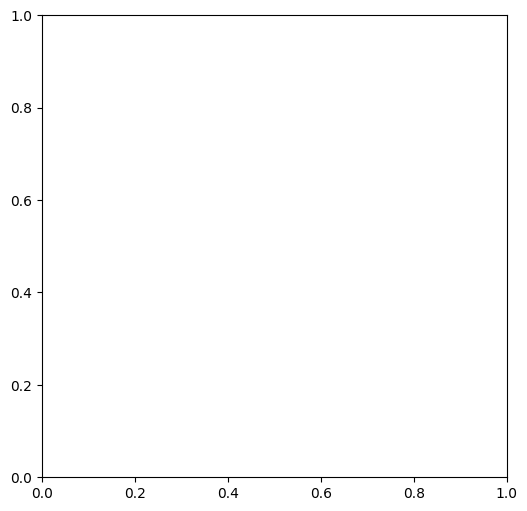

In [13]:
from ase.io import read
from ase.visualize.plot import plot_atoms
import matplotlib.pyplot as plt

structure = cif_string

# Atoms only
fig1 = plt.figure(figsize=(6, 6))
plot_atoms(structure, ax=fig1.add_subplot(111), radii=0.4, show_unit_cell=0)
plt.title("Material (Atoms Only)")
plt.tight_layout()
plt.savefig("material_only.png")
plt.close()

# Unit cell
fig2 = plt.figure(figsize=(6, 6))
plot_atoms(structure, ax=fig2.add_subplot(111), radii=0.1, show_unit_cell=2)
plt.title("Unit Cell")
plt.tight_layout()
plt.savefig("unit_cell_only.png")
plt.close()


In [14]:
cif_string

"# generated using pymatgen\ndata_HoWClO4\n_symmetry_space_group_name_H-M   'P 1'\n_cell_length_a   6.34135853\n_cell_length_b   6.34135853\n_cell_length_c   6.97127782\n_cell_angle_alpha   75.51587318\n_cell_angle_beta   75.51587318\n_cell_angle_gamma   70.55018101\n_symmetry_Int_Tables_number   1\n_chemical_formula_structural   HoWClO4\n_chemical_formula_sum   'Ho2 W2 Cl2 O8'\n_cell_volume   251.62630547\n_cell_formula_units_Z   2\nloop_\n _symmetry_equiv_pos_site_id\n _symmetry_equiv_pos_as_xyz\n  1  'x, y, z'\nloop_\n _atom_site_type_symbol\n _atom_site_label\n _atom_site_symmetry_multiplicity\n _atom_site_fract_x\n _atom_site_fract_y\n _atom_site_fract_z\n _atom_site_occupancy\n  Ho  Ho0  1  0.77753900  0.77753900  0.11781000  1\n  Ho  Ho1  1  0.22246100  0.22246100  0.88219000  1\n  W  W2  1  0.63689200  0.63689200  0.73345600  1\n  W  W3  1  0.36310800  0.36310800  0.26654400  1\n  Cl  Cl4  1  0.98890600  0.98890600  0.77062300  1\n  Cl  Cl5  1  0.01109400  0.01109400  0.2293770

<!-- visualization of the reconstructed ones -->

In [9]:
import torch
test = torch.load('/home/jamshid/workspace/nima/cdvae/hydra/singlerun/2025-04-01/gpu_enabled/eval_gen.pt')

In [10]:
test

{'eval_setting': Namespace(model_path='/home/jamshid/workspace/nima/cdvae/hydra/singlerun/2025-04-01/gpu_enabled/', tasks=['recon', 'gen', 'opt'], n_step_each=100, step_lr=0.0001, min_sigma=0, save_traj=False, disable_bar=False, num_evals=1, num_batches_to_samples=20, start_from='data', batch_size=500, force_num_atoms=False, force_atom_types=False, down_sample_traj_step=10, label=''),
 'frac_coords': tensor([[[0.2886, 0.8840, 0.8467],
          [0.8813, 0.4848, 0.0496],
          [0.4788, 0.0864, 0.2500],
          ...,
          [0.4896, 0.8162, 0.9865],
          [0.7098, 0.9906, 0.5547],
          [0.8815, 0.6486, 0.2702]]]),
 'num_atoms': tensor([[ 5, 12, 16,  ..., 20,  8, 15]]),
 'atom_types': tensor([[9, 9, 9,  ..., 8, 8, 8]]),
 'lengths': tensor([[[ 3.9455,  4.1625,  5.4137],
          [ 4.9605,  6.5342,  7.2233],
          [ 5.9923,  6.6808,  6.9604],
          ...,
          [ 8.0568,  8.0494, 10.4544],
          [ 5.4700,  5.4826,  5.8046],
          [ 6.8295,  6.8387,  6.546

In [16]:
pip install pymatgen py3Dmol



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [17]:
from pymatgen.core import Structure
import py3Dmol

# Paste your CIF string here
cif_str = """
data_HoWClO4
_symmetry_space_group_name_H-M   'P 1'
_cell_length_a   6.34135853
_cell_length_b   6.34135853
_cell_length_c   6.97127782
_cell_angle_alpha   75.51587318
_cell_angle_beta   75.51587318
_cell_angle_gamma   70.55018101
_symmetry_Int_Tables_number   1
_chemical_formula_structural   HoWClO4
_chemical_formula_sum   'Ho2 W2 Cl2 O8'
_cell_volume   251.62630547
_cell_formula_units_Z   2
loop_
 _symmetry_equiv_pos_site_id
 _symmetry_equiv_pos_as_xyz
  1  'x, y, z'
loop_
 _atom_site_type_symbol
 _atom_site_label
 _atom_site_symmetry_multiplicity
 _atom_site_fract_x
 _atom_site_fract_y
 _atom_site_fract_z
 _atom_site_occupancy
  Ho  Ho0  1  0.77753900  0.77753900  0.11781000  1
  Ho  Ho1  1  0.22246100  0.22246100  0.88219000  1
  W  W2  1  0.63689200  0.63689200  0.73345600  1
  W  W3  1  0.36310800  0.36310800  0.26654400  1
  Cl  Cl4  1  0.98890600  0.98890600  0.77062300  1
  Cl  Cl5  1  0.01109400  0.01109400  0.22937700  1
  O  O6  1  0.70412000  0.70412000  0.46373300  1
  O  O7  1  0.29588000  0.29588000  0.53626700  1
  O  O8  1  0.54626200  0.54626200  0.19357400  1
  O  O9  1  0.45373800  0.45373800  0.80642600  1
  O  O10  1  0.10625700  0.49210200  0.15525600  1
  O  O11  1  0.49210200  0.10625700  0.15525600  1
  O  O12  1  0.89374300  0.50789800  0.84474400  1
  O  O13  1  0.50789800  0.89374300  0.84474400  1
"""

# Parse the structure
structure = Structure.from_str(cif_str, fmt="cif")

# Create 3Dmol view for unit cell only
view = py3Dmol.view()
view.addModel(structure.to(fmt="xyz"), "xyz")
view.setStyle({'sphere': {'scale': 0.0}, 'stick': {'radius': 0.0}})  # hide atoms
view.addUnitCell()  # show only unit cell
view.zoomTo()
view.show()


ValueError: Invalid fmt='xyz', valid options are ('cif', 'poscar', 'cssr', 'json', 'yaml', 'yml', 'xsf', 'mcsqs', 'res', 'pwmat', '')